## CIFAR10 EXPERIMENTS

### NOTES
* All models run on a single GTX 1060 3GB, i5 8600k and 16GB RAM
* Purpose of the experiments is to get practical experience in building simple models and working with established datasets
* In the future, I would like to work with more complex models and datasets

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
'''
Unpickling helper function to read from  file and return data
'''
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
'''
Load pickled CIFAR-10 Data
'''
def load_all_cifar_data():
    folder_path = 'cifar-10-batches-py'
    data = []
    labels = []
    for i in range(1,6):
        batch = unpickle(f'{folder_path}/data_batch_{i}')
        data.append(batch[b'data'])
        labels.append(batch[b'labels'])
    
    test_data = unpickle(f'{folder_path}/test_batch')
    
    return np.concatenate(tuple(data), axis=0), np.concatenate(tuple(labels), axis=0), test_data[b'data'], test_data[b'labels']

In [4]:
def convert_data_for_cnn(data, rows=50000):
    num_entries_in_channel = int(data.shape[1] / 3)
    data_4d = np.zeros((rows,3,32,32))
    for i in range(rows):
        x = data[i]
        r_1d = x[0:num_entries_in_channel]
        g_1d = x[num_entries_in_channel:2*num_entries_in_channel]
        b_1d = x[num_entries_in_channel*2:]

        r_2d = np.reshape(r_1d, (32,32))
        g_2d = np.reshape(g_1d, (32,32))
        b_2d = np.reshape(b_1d, (32,32))
        
        image_3d = np.zeros((3,32,32))
        image_3d[0] = r_2d
        image_3d[1] = g_2d
        image_3d[2] = b_2d
                
        data_4d[i] = image_3d
    print(data_4d.shape)
    data_4d = np.swapaxes(data_4d,1,3)
    data_4d = np.swapaxes(data_4d, 1,2)
    
    mean = np.mean(data_4d,axis=(0,1,2,3))
    std = np.std(data_4d,axis=(0,1,2,3))
    data_4d = (data_4d-mean)/(std+1e-7)
    return data_4d

In [5]:
data, labels, test_x, test_y = load_all_cifar_data()

In [6]:
one_hot_placeholder = np.zeros((50000,10))
one_hot_placeholder[np.arange(50000), labels] = 1 # One hot conversion for labeled data
labels = one_hot_placeholder

one_hot_placeholder = np.zeros((10000,10))
one_hot_placeholder[np.arange(10000), test_y] = 1 # One hot conversion for labeled data
test_y = one_hot_placeholder

print(data.shape)
print(labels.shape)
print(test_y.shape)

(50000, 3072)
(50000, 10)
(10000, 10)


In [7]:
data = np.divide(data, 255) # normalize all image data
train_x = np.divide(test_x, 255)
import os 
os.makedirs('models', exist_ok=True)

# Plain Neural Network

### Summary
* Plain neural network architeture fed with a flattened version of the images. 
* Achieved around 50% accuracy which is clearly better than random (10%) but still can be improved

### Benifits
* Fast to train due to its simplicity
* Easy conceptual model for beginners

In [8]:
model = tf.keras.Sequential()
from tensorflow.keras.layers import Dense
model.add(Dense(units=1024, activation='relu', input_dim=3072))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

W1006 21:53:14.075599 140195412502336 deprecation.py:506] From /home/nagianek/anaconda3/envs/ml-sandbox/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              3146752   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 3,805,450
Trainable params: 3,805,450
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(data, labels, validation_split=0.20, epochs=30, batch_size=64)

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 4s 100us/sample - loss: 1.8982 - acc: 0.3118 - val_loss: 1.7556 - val_acc: 0.3687
Epoch 2/30
40000/40000 [==============================] - 5s 137us/sample - loss: 1.6903 - acc: 0.3904 - val_loss: 1.6649 - val_acc: 0.3998
Epoch 3/30
40000/40000 [==============================] - 5s 137us/sample - loss: 1.6093 - acc: 0.4193 - val_loss: 1.6153 - val_acc: 0.4238
Epoch 4/30
40000/40000 [==============================] - 5s 137us/sample - loss: 1.5523 - acc: 0.4435 - val_loss: 1.6312 - val_acc: 0.4100
Epoch 5/30
40000/40000 [==============================] - 5s 137us/sample - loss: 1.5041 - acc: 0.4607 - val_loss: 1.5706 - val_acc: 0.4441
Epoch 6/30
40000/40000 [==============================] - 5s 137us/sample - loss: 1.4633 - acc: 0.4773 - val_loss: 1.5477 - val_acc: 0.4545
Epoch 7/30
40000/40000 [==============================] - 5s 137us/sample - loss: 1.4322 - acc: 0.4862 - val_l

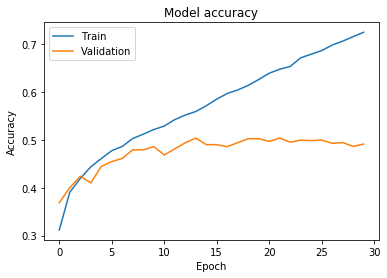

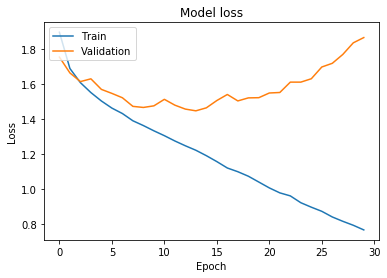

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
model.save('models/simple-nn.h5')

# Convolutional Neural Network

### Summary
* Proven to be better technique when working with images hence, much better performance that simple NN
* Achieves validation accuracy of 75% in a fairly small number of epochs

### Benifits
* Reuse of kernels/weights that are learnt and convolved over the image, thus allowing the model to learn features
* Smaller number of parameters than NN

In [13]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

In [14]:
from tensorflow.keras.optimizers import RMSprop

# initiate RMSprop optimizer
opt = RMSprop(learning_rate=0.001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)       

In [15]:
history = model.fit(convert_data_for_cnn(data), labels, validation_split=0.2, epochs=30, batch_size=64, shuffle=True)

(50000, 3, 32, 32)
Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 11s 270us/sample - loss: 1.5562 - acc: 0.4381 - val_loss: 1.1816 - val_acc: 0.5802
Epoch 2/30
40000/40000 [==============================] - 10s 245us/sample - loss: 1.1396 - acc: 0.5974 - val_loss: 0.9787 - val_acc: 0.6617
Epoch 3/30
40000/40000 [==============================] - 10s 247us/sample - loss: 0.9713 - acc: 0.6616 - val_loss: 0.8260 - val_acc: 0.7090
Epoch 4/30
40000/40000 [==============================] - 10s 241us/sample - loss: 0.8837 - acc: 0.6947 - val_loss: 0.8476 - val_acc: 0.7099
Epoch 5/30
40000/40000 [==============================] - 10s 245us/sample - loss: 0.8205 - acc: 0.7159 - val_loss: 0.7921 - val_acc: 0.7304
Epoch 6/30
40000/40000 [==============================] - 10s 251us/sample - loss: 0.7800 - acc: 0.7301 - val_loss: 0.7650 - val_acc: 0.7381
Epoch 7/30
40000/40000 [==============================] - 10s 252us/sample - loss: 0.

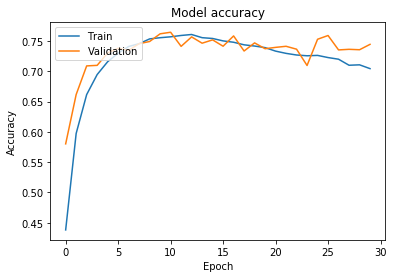

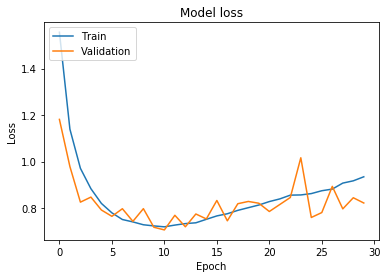

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
model.save('models/simple-cnn-model.h5')

# CNN WITH SEPERABLE CONVOLUTIONS

### Summary
* Much less amount of computations involved due to use of depthwise and pointwise convolutions
* Still achieved validation accuracy similar to plain CNN
* Efficient and Faster for inference and training

In [18]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, DepthwiseConv2D, BatchNormalization
from tensorflow.keras.models import Sequential

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(16, kernel_size=(1,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, kernel_size=(1,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))

In [19]:
from tensorflow.keras.optimizers import RMSprop

# initiate RMSprop optimizer
opt = RMSprop(learning_rate=0.001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 16, 16, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 16, 16, 32)       

In [20]:
history = model.fit(convert_data_for_cnn(data), labels, validation_split=0.2, epochs=30, batch_size=64, shuffle=True)

(50000, 3, 32, 32)
Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 13s 327us/sample - loss: 1.7654 - acc: 0.3569 - val_loss: 1.5231 - val_acc: 0.4437
Epoch 2/30
40000/40000 [==============================] - 12s 310us/sample - loss: 1.3995 - acc: 0.4957 - val_loss: 1.3394 - val_acc: 0.5254
Epoch 3/30
40000/40000 [==============================] - 13s 327us/sample - loss: 1.2742 - acc: 0.5452 - val_loss: 1.2589 - val_acc: 0.5479
Epoch 4/30
40000/40000 [==============================] - 14s 355us/sample - loss: 1.1965 - acc: 0.5760 - val_loss: 1.1952 - val_acc: 0.5719
Epoch 5/30
40000/40000 [==============================] - 13s 330us/sample - loss: 1.1341 - acc: 0.5994 - val_loss: 1.1050 - val_acc: 0.6077
Epoch 6/30
40000/40000 [==============================] - 13s 335us/sample - loss: 1.0907 - acc: 0.6125 - val_loss: 1.1022 - val_acc: 0.6067
Epoch 7/30
40000/40000 [==============================] - 14s 343us/sample - loss: 1.

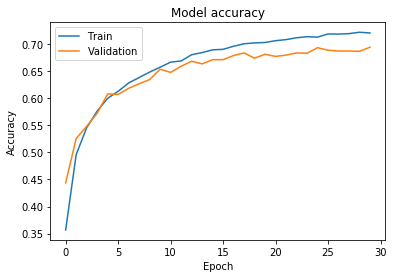

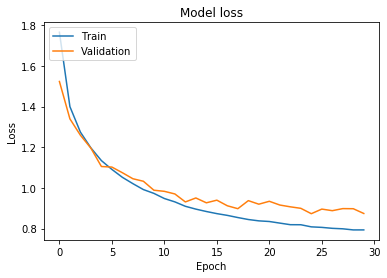

In [21]:
%matplotlib inline

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [22]:
model.save('models/seperable-cnn-model.h5')

# CNN 64x3

### Summary
* Much more params that any other CNN thus a more complex of a model
* Using kernel regularizer of 0.0001 to prevent high variance, tried using 0.001 but achieved worse results
* Best model in all of the experiments in terms of validation accuracy
* Takes longer to train overall

In [23]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

model = Sequential()

weight_decay = 0.0001
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))

In [24]:
from tensorflow.keras.optimizers import Adam

# initiate RMSprop optimizer
opt = Adam(learning_rate=0.001)

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_14 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)       

In [25]:
history = model.fit(convert_data_for_cnn(data), labels, validation_split=0.2, epochs=30, batch_size=64, shuffle=True)

(50000, 3, 32, 32)
Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 12s 309us/sample - loss: 1.7751 - acc: 0.4249 - val_loss: 1.2547 - val_acc: 0.5648
Epoch 2/30
40000/40000 [==============================] - 13s 336us/sample - loss: 1.1743 - acc: 0.6024 - val_loss: 0.9702 - val_acc: 0.6688
Epoch 3/30
40000/40000 [==============================] - 13s 316us/sample - loss: 0.9579 - acc: 0.6796 - val_loss: 0.8375 - val_acc: 0.7214
Epoch 4/30
40000/40000 [==============================] - 13s 313us/sample - loss: 0.8523 - acc: 0.7223 - val_loss: 0.8241 - val_acc: 0.7337
Epoch 5/30
40000/40000 [==============================] - 13s 322us/sample - loss: 0.7800 - acc: 0.7491 - val_loss: 0.7922 - val_acc: 0.7487
Epoch 6/30
40000/40000 [==============================] - 13s 324us/sample - loss: 0.7307 - acc: 0.7662 - val_loss: 0.7494 - val_acc: 0.7631
Epoch 7/30
40000/40000 [==============================] - 13s 319us/sample - loss: 0.

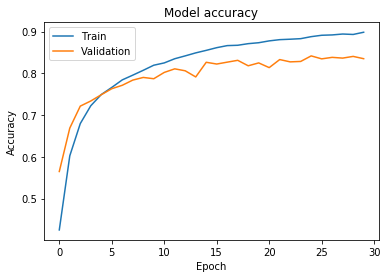

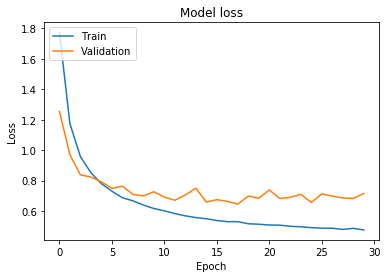

In [26]:
%matplotlib inline

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [27]:
model.save('models/deep-cnn-model.h5')

## Test Set Analysis
### Summary:
* As expected, depp-cnn-model (64x3 CNN) has the highest test accuracy of 83%
* Better results should be achieveable by using data augmentation as well as more complex architectures

In [28]:
def load_models():
    from tensorflow.keras.models import load_model
    import os
    
    all_models = []
    for model in os.listdir('models'):
        all_models.append((model,load_model('models/'+model)))
    
    return all_models

In [29]:
models = load_models()

W1006 22:13:48.681095 140195412502336 deprecation.py:506] From /home/nagianek/anaconda3/envs/ml-sandbox/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1006 22:13:48.683565 140195412502336 deprecation.py:506] From /home/nagianek/anaconda3/envs/ml-sandbox/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1006 22:13:48.747585 140195412502336 deprecation.py:506] From /home/nagianek/anaconda3/envs/ml-sandbox/lib/python3.7/site-packages/tensorflow/python/ops/init_ops

In [30]:
for model in models:
    print(f'Evaluating {model[0]}')
    if len(model[1].input_shape) == 4:
        model[1].evaluate(x=convert_data_for_cnn(test_x,10000), y=test_y)
    else:
        model[1].evaluate(x=test_x, y=test_y)

Evaluating deep-cnn-model.h5
(10000, 3, 32, 32)
10000/10000 [==============================] - 3s 255us/sample - loss: 0.7291 - acc: 0.8293
Evaluating resnet-20-200-epochs.h5
(10000, 3, 32, 32)
10000/10000 [==============================] - 4s 412us/sample - loss: 0.4285 - acc: 0.9192
Evaluating simple-nn.h5
10000/10000 [==============================] - 1s 66us/sample - loss: 426.0805 - acc: 0.4401
Evaluating seperable-cnn-model.h5
(10000, 3, 32, 32)
10000/10000 [==============================] - 1s 116us/sample - loss: 0.8665 - acc: 0.7008
Evaluating simple-cnn-model.h5
(10000, 3, 32, 32)
10000/10000 [==============================] - 2s 188us/sample - loss: 0.8289 - acc: 0.7420


## BONUS: Resnet

In [8]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import os

In [9]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [10]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [11]:
def resnet_v1(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [12]:
model = resnet_v1(input_shape=(32,32,3), depth=20)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
________________________________________________________________________

In [13]:
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

In [14]:
datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

datagen.fit(convert_data_for_cnn(data))

# Fit the model on the batches generated by datagen.flow().
history = model.fit_generator(datagen.flow(convert_data_for_cnn(data), labels, batch_size=32),
                    validation_data=(convert_data_for_cnn(test_x,10000), test_y),
                    epochs=200, verbose=1,
                    callbacks=callbacks)

(50000, 3, 32, 32)
(50000, 3, 32, 32)
(10000, 3, 32, 32)
Learning rate:  0.001
Epoch 1/200
1563/1563 [==============================] - 40s 25ms/step - loss: 1.5679 - acc: 0.4937 - val_loss: 1.5535 - val_acc: 0.5208
Learning rate:  0.001
Epoch 2/200
1563/1563 [==============================] - 36s 23ms/step - loss: 1.1606 - acc: 0.6460 - val_loss: 1.2327 - val_acc: 0.6336
Learning rate:  0.001
Epoch 3/200
1563/1563 [==============================] - 36s 23ms/step - loss: 1.0033 - acc: 0.7074 - val_loss: 1.0575 - val_acc: 0.7010
Learning rate:  0.001
Epoch 4/200
1563/1563 [==============================] - 36s 23ms/step - loss: 0.9138 - acc: 0.7402 - val_loss: 1.2441 - val_acc: 0.6465
Learning rate:  0.001
Epoch 5/200
1563/1563 [==============================] - 35s 22ms/step - loss: 0.8558 - acc: 0.7642 - val_loss: 1.7199 - val_acc: 0.5916
Learning rate:  0.001
Epoch 6/200
1563/1563 [==============================] - 36s 23ms/step - loss: 0.8147 - acc: 0.7787 - val_loss: 1.2710 - val_a

Learning rate:  0.001
Epoch 52/200
1563/1563 [==============================] - 35s 22ms/step - loss: 0.5162 - acc: 0.8940 - val_loss: 0.6661 - val_acc: 0.8533
Learning rate:  0.001
Epoch 53/200
1563/1563 [==============================] - 36s 23ms/step - loss: 0.5136 - acc: 0.8932 - val_loss: 0.6601 - val_acc: 0.8520
Learning rate:  0.001
Epoch 54/200
1563/1563 [==============================] - 37s 24ms/step - loss: 0.5142 - acc: 0.8918 - val_loss: 0.8634 - val_acc: 0.8007
Learning rate:  0.001
Epoch 55/200
1563/1563 [==============================] - 36s 23ms/step - loss: 0.5120 - acc: 0.8957 - val_loss: 0.7058 - val_acc: 0.8427
Learning rate:  0.001
Epoch 56/200
1563/1563 [==============================] - 36s 23ms/step - loss: 0.5088 - acc: 0.8962 - val_loss: 0.6429 - val_acc: 0.8558
Learning rate:  0.001
Epoch 57/200
1563/1563 [==============================] - 35s 23ms/step - loss: 0.5114 - acc: 0.8942 - val_loss: 0.6901 - val_acc: 0.8466
Learning rate:  0.001
Epoch 58/200
1563/

1563/1563 [==============================] - 36s 23ms/step - loss: 0.2481 - acc: 0.9668 - val_loss: 0.4425 - val_acc: 0.9162
Learning rate:  0.0001
Epoch 104/200
1563/1563 [==============================] - 35s 23ms/step - loss: 0.2438 - acc: 0.9672 - val_loss: 0.4566 - val_acc: 0.9102
Learning rate:  0.0001
Epoch 105/200
1563/1563 [==============================] - 36s 23ms/step - loss: 0.2409 - acc: 0.9684 - val_loss: 0.4456 - val_acc: 0.9122
Learning rate:  0.0001
Epoch 106/200
1563/1563 [==============================] - 35s 23ms/step - loss: 0.2356 - acc: 0.9690 - val_loss: 0.4455 - val_acc: 0.9123
Learning rate:  0.0001
Epoch 107/200
1563/1563 [==============================] - 36s 23ms/step - loss: 0.2353 - acc: 0.9693 - val_loss: 0.4485 - val_acc: 0.9124
Learning rate:  0.0001
Epoch 108/200
1563/1563 [==============================] - 36s 23ms/step - loss: 0.2294 - acc: 0.9705 - val_loss: 0.4570 - val_acc: 0.9098
Learning rate:  0.0001
Epoch 109/200
1563/1563 [=================

Learning rate:  1e-05
Epoch 154/200
1563/1563 [==============================] - 36s 23ms/step - loss: 0.1724 - acc: 0.9847 - val_loss: 0.4290 - val_acc: 0.9179
Learning rate:  1e-05
Epoch 155/200
1563/1563 [==============================] - 35s 23ms/step - loss: 0.1739 - acc: 0.9834 - val_loss: 0.4290 - val_acc: 0.9180
Learning rate:  1e-05
Epoch 156/200
1563/1563 [==============================] - 35s 23ms/step - loss: 0.1734 - acc: 0.9839 - val_loss: 0.4301 - val_acc: 0.9179
Learning rate:  1e-05
Epoch 157/200
1563/1563 [==============================] - 36s 23ms/step - loss: 0.1722 - acc: 0.9837 - val_loss: 0.4304 - val_acc: 0.9179
Learning rate:  1e-05
Epoch 158/200
1563/1563 [==============================] - 36s 23ms/step - loss: 0.1718 - acc: 0.9843 - val_loss: 0.4300 - val_acc: 0.9189
Learning rate:  1e-05
Epoch 159/200
1563/1563 [==============================] - 36s 23ms/step - loss: 0.1696 - acc: 0.9853 - val_loss: 0.4310 - val_acc: 0.9192
Learning rate:  1e-05
Epoch 160/20

In [15]:
model.save('models/resnet-20-200-epochs.h5')

### Summary:
* As expected, resnet-20 has the highest performance of all models due to the deep nature of the model
* It took around 2 hours to train 200 epochs which clearly is a decent amount of time
* In the end, the model has a 91% test set accuracy which outperforms every other model but comes at the expense of hiigher computation cost